# Training TCR sequence embeddings

In [935]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [936]:
from gensim.models import Word2Vec
import multiprocessing
import pandas as pd
import numpy as np

from scipy.spatial.distance import cosine
from modlamp.descriptors import GlobalDescriptor

from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
from tqdm.notebook import trange, tqdm

#### Loading data

In [937]:
# Path to the most recent data collated from the DBs
path = "data/input/collated/collated.csv"

df = pd.read_csv(path, sep=",", dtype=str)

In [939]:
df

,cdr3a,cdr3b,epitope,source
0,IVVRSSNTGKLI,ASSQDRDTQY,VMAPRTLIL,iedb
1,NaN,ASSLGQAYEQY,FLRGRAYGL,iedb
2,NaN,ASSLGQAYEQY,FLRGRFYGL,iedb
3,NaN,ASSLGQAYEQY,EEYLKAWTF,iedb
4,NaN,ASSLGQAYEQY,EEYLQAFTY,iedb
...,...,...,...,...
112056,CWSPFGNEKLTF,CASSLGQGSYEQYF,GTSGSPIVNR,vdjdb
112057,CWSPFGNEKLTF,CASSLGQGSYEQYF,GTSGSPIINR,vdjdb
112058,CAVTPDGQKLLF,CASSPGTSGRAWNNEQFF,NLVPMVATV,vdjdb
112059,SSGNQFYF,CASSQQTGTIGGYTF,NLVPMVATV,vdjdb


#### Featurizing sequences

In [940]:
# Define functions for creating k-mers from sequences


def kmerise(input_string, k, offset=0):
    length = len(input_string)
    result = []

    for i in range(offset, length - k + 1, k):
        result.append(input_string[i : i + k])

    return result


def framerise(input_string, k):
    result = []

    for i in range(k):
        result.append(kmerise(input_string, k, offset=i))

    return result


def framerise_array(input_array, k):
    result = []

    for a in input_array:
        result.extend(framerise(a, k))

    return result

In [941]:
# Grab CDR3β sequences from the input data
sequences = df["cdr3b"].unique().tolist()

cdr3a = df["cdr3a"].dropna()
cdr3a = cdr3a[~cdr3a.str.contains(regex)]
cdr3a = cdr3a.unique().tolist()

sequences = sequences + cdr3a

In [942]:
# Create an array of frame-shifted (overlapping) k-mer sentences
k = 3
sentences = framerise_array(sequences, k)

#### Training embeddings

In [943]:
n_dimensions = 1000
window = 5
min_count = 1
negative = 15
epochs = 20
workers = multiprocessing.cpu_count()

model = Word2Vec(
    sentences,
    size=n_dimensions,
    window=window,
    min_count=min_count,
    negative=negative,
    iter=epochs,
    workers=workers,
)

In [944]:
# Extract the trained embeddings as a KeyedVector
embeddings = model.wv

#### Evaluate the embeddings

In [945]:
# Retrieve the list of kmers for which we have trained embeddings
kmers = embeddings.index2word

In [946]:
# Use modlamp to calculate features for each of the kmers
desc = GlobalDescriptor(kmers)
desc.calculate_all()

In [947]:
kmer_features = pd.DataFrame(desc.descriptor, columns=desc.featurenames)
kmer_features["kmer"] = kmers
kmer_features["embedding"] = ""
kmer_features

,Length,MW,Charge,ChargeDensity,pI,InstabilityInd,Aromaticity,AliphaticInd,BomanInd,HydrophRatio,kmer,embedding
0,3.0,278.33,0.836,0.003004,8.759766,6.666667,0.000000,33.333333,0.103333,0.666667,CAS,
1,3.0,262.27,0.990,0.003775,12.250000,70.866667,0.000000,33.333333,1.663333,0.333333,ASS,
2,3.0,455.51,0.988,0.002169,9.740234,-18.466667,0.666667,0.000000,0.900000,0.333333,QYF,
3,3.0,409.44,0.988,0.002413,9.740234,-43.600000,0.333333,0.000000,2.750000,0.000000,TQY,
4,3.0,304.35,0.990,0.003253,12.250000,70.866667,0.000000,130.000000,0.626667,0.333333,SSL,
...,...,...,...,...,...,...,...,...,...,...,...,...
7342,3.0,481.62,0.990,0.002056,12.250000,6.666667,0.666667,0.000000,-2.553333,0.666667,MWF,
7343,3.0,310.40,0.682,0.002197,8.096680,115.333333,0.000000,0.000000,0.280000,0.666667,SCC,
7344,3.0,431.45,1.029,0.002385,9.740234,47.800000,0.333333,0.000000,3.813333,0.000000,NYH,
7345,3.0,354.43,0.836,0.002359,8.759766,6.666667,0.333333,0.000000,-0.286667,0.666667,CFS,


Feature Names:

Sequence Length  
Molecular Weight  
Sequence Charge  
Charge Density  
Isoelectric Point  
Instability Index  
Aromaticity  
Aliphatic Index  
Boman Index  
Hydrophobic Ratio  

https://modlamp.org/modlamp.html#modlamp.descriptors.GlobalDescriptor

In [948]:
# Add the embedding vectors to the dataframe
for i in range(len(kmer_features)):
    kmer_features.at[i, "embedding"] = embeddings[kmer_features.loc[i, "kmer"]]

In [949]:
# Run a 2D PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(kmer_features["embedding"].tolist())
kmer_features["pca1"] = pca_result[:, 0]
kmer_features["pca2"] = pca_result[:, 1]

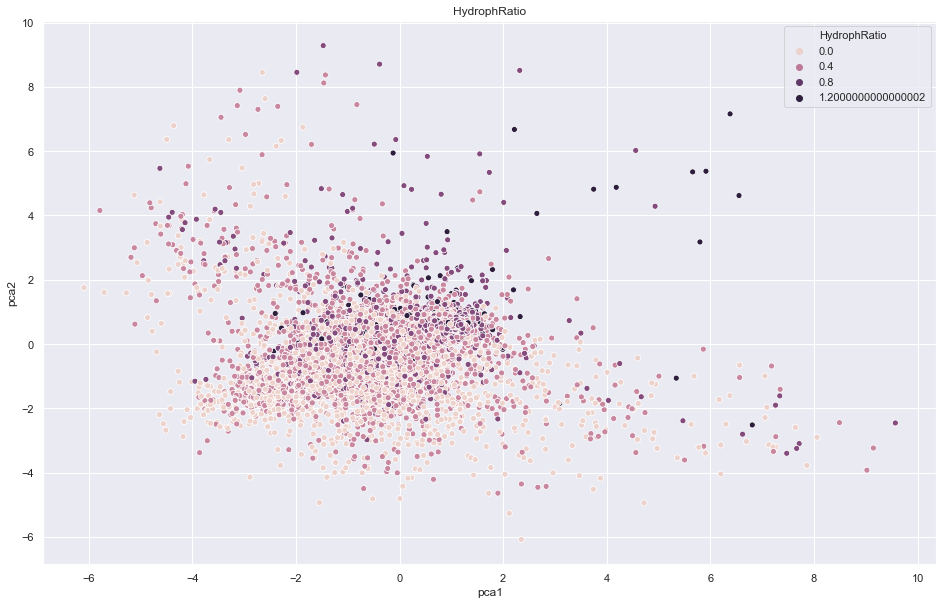

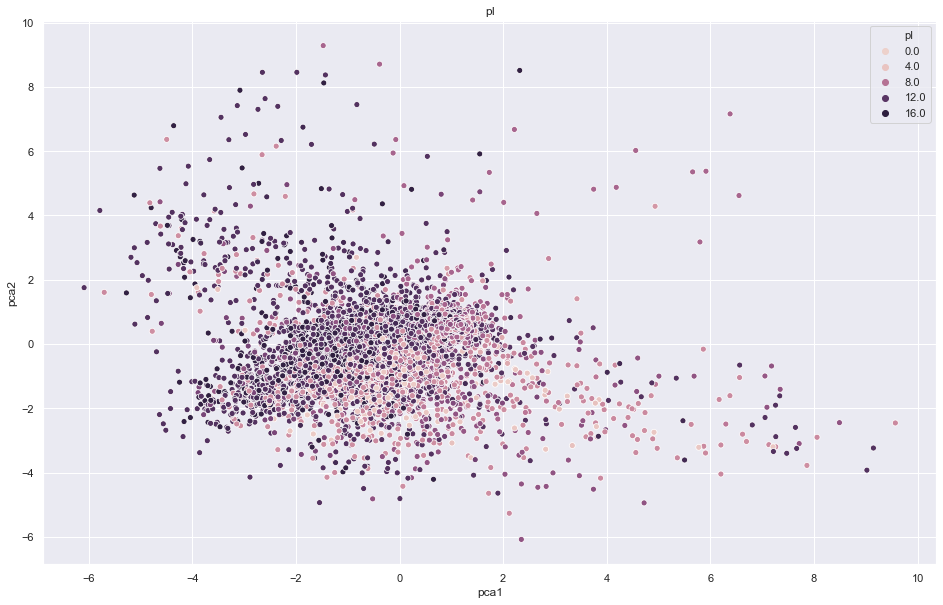

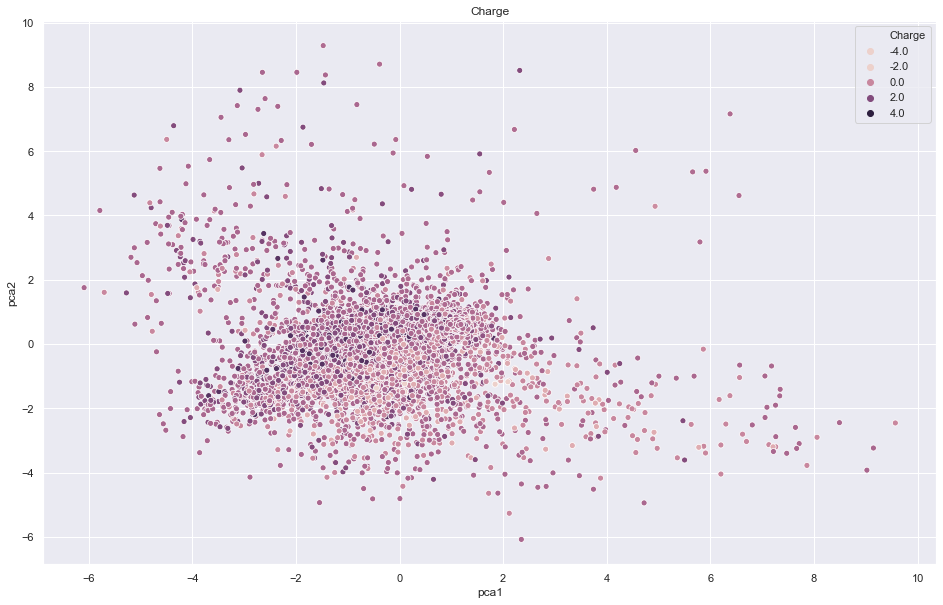

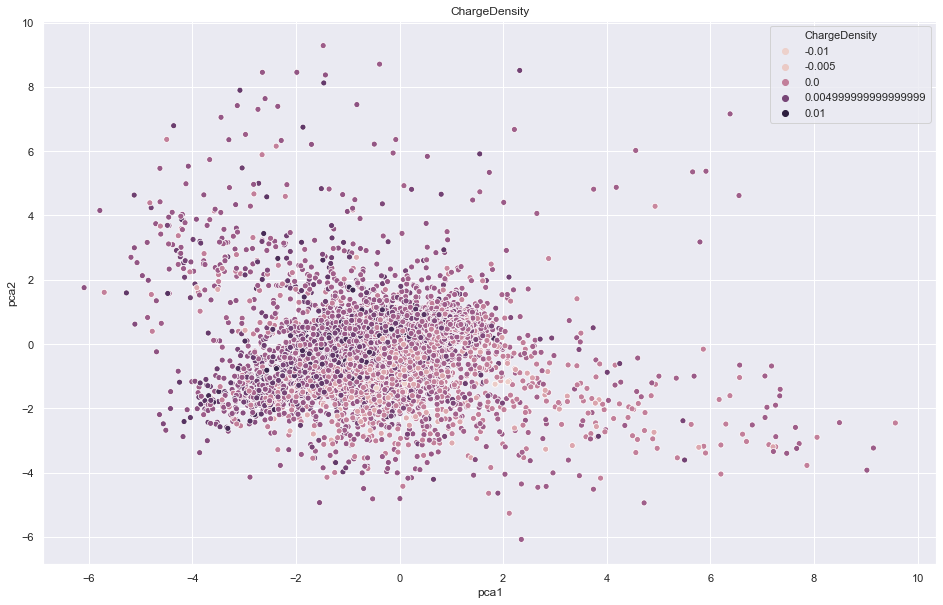

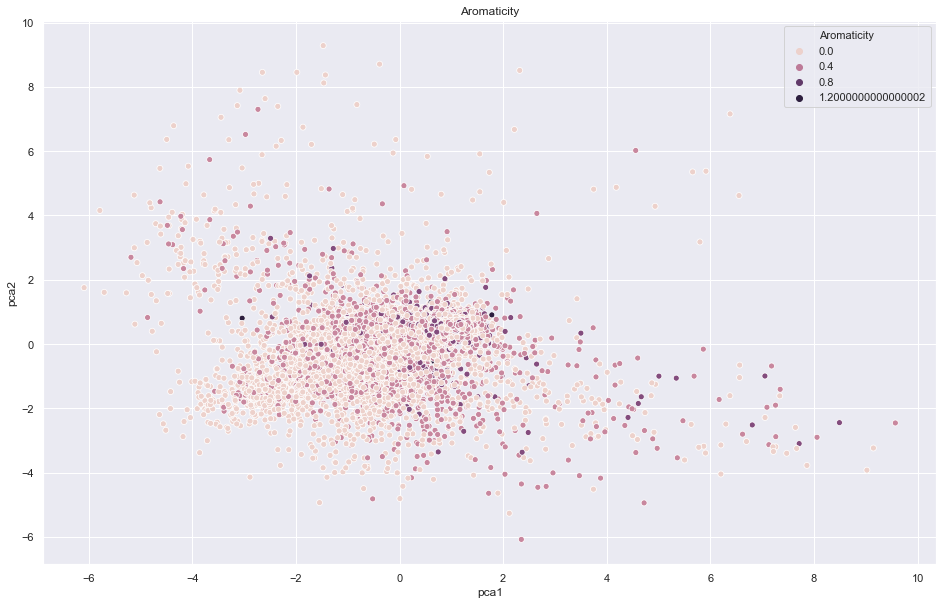

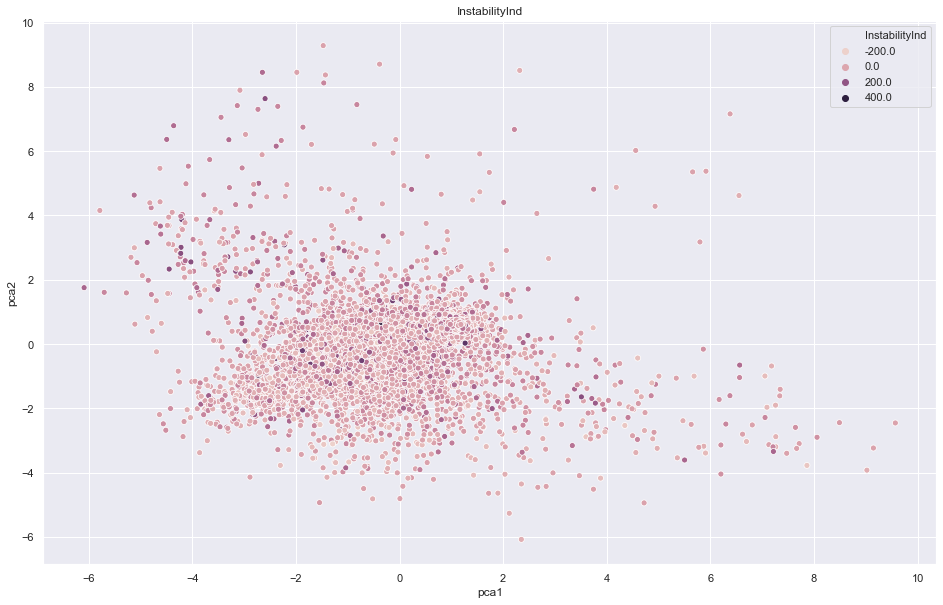

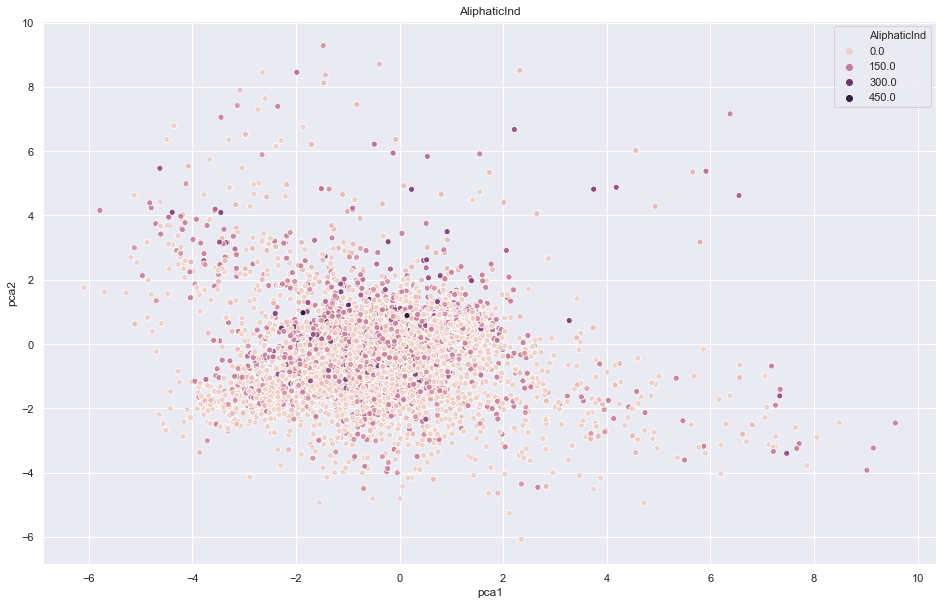

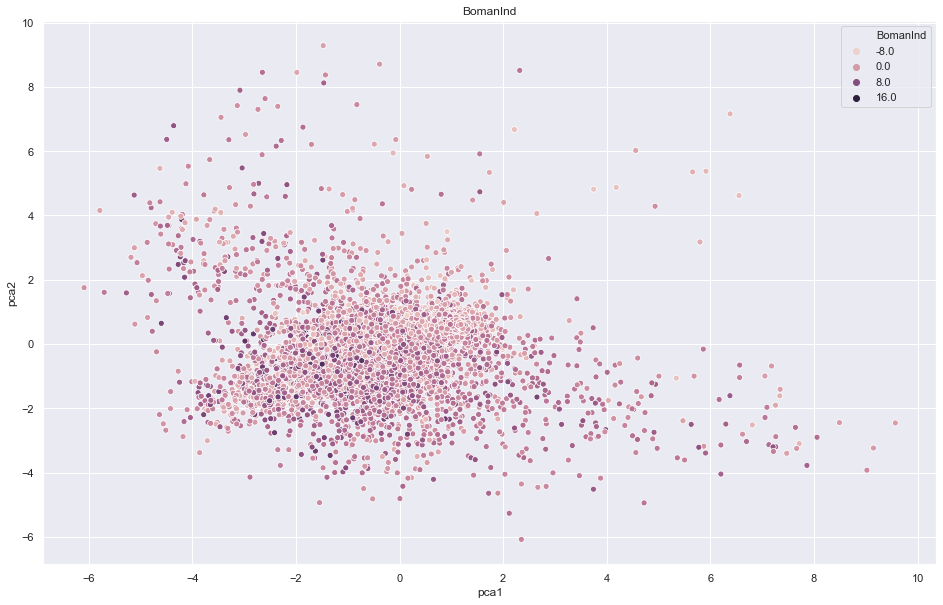

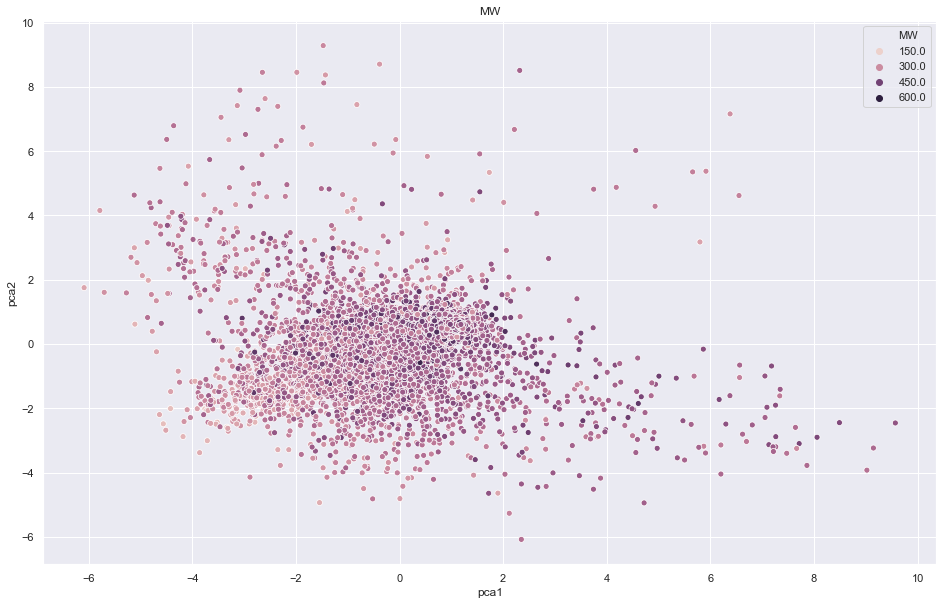

In [964]:
# Plot the PCA results
features = [
    "HydrophRatio",
    "pI",
    "Charge",
    "ChargeDensity",
    "Aromaticity",
    "InstabilityInd",
    "AliphaticInd",
    "BomanInd",
    "MW",
]


for feature in features:
    plt.figure()
    cmap = sns.cubehelix_palette(as_cmap=True)
    # sns.set(rc={"figure.figsize": (16, 10)})
    sns.scatterplot(
        data=kmer_features,
        x="pca1",
        y="pca2",
        #    legend="full",
        hue=feature,
        cmap=cmap,
    ).set_title(feature)

#### Visualise the trained embeddings

In [951]:
# Define a function to convert an array of TCR sequences to k frame vectors using the trained embedding
def tcr2vec(sequences, embeddings, k):
    tcr_vecs = {}

    for sequence in sequences:
        frames = framerise(sequence, k)

        vecs = []
        for frame in frames:
            vec = np.zeros(embeddings.vector_size)
            for kmer in frame:
                vec = vec + embeddings.get_vector(kmer)
            vecs = vecs + vec.tolist()
        tcr_vecs[sequence] = vecs

    return tcr_vecs

In [952]:
tcr_vecs = tcr2vec(sequences, embeddings, k=3)

In [953]:
X = pd.DataFrame(list(tcr_vecs.items()), columns=["tcr", "vec"])

In [954]:
X2 = df.loc[df["epitope"] != "-", ["cdr3b", "epitope"]].drop_duplicates()

X2.columns = ["tcr", "epitope"]

X = X.merge(X2, on="tcr", how="inner")

In [955]:
# Plot the top N epitopes by degeneracy
n = 7

top_epitopes = (
    X2.groupby("epitope")
    .size()
    .reset_index(name="count")
    .sort_values(by=["count"], ascending=False)
)

top_n = list(top_epitopes.head(n)["epitope"])

X["palette"] = "other"
X["palette"][X["epitope"].isin(top_n)] = X["epitope"]

In [956]:
# tsne = TSNE(n_components=2, perplexity=30)
# tsne_data = tsne.fit_transform(list(X["vec"]))

In [957]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(list(X["vec"]))
tsne_data = pca_result

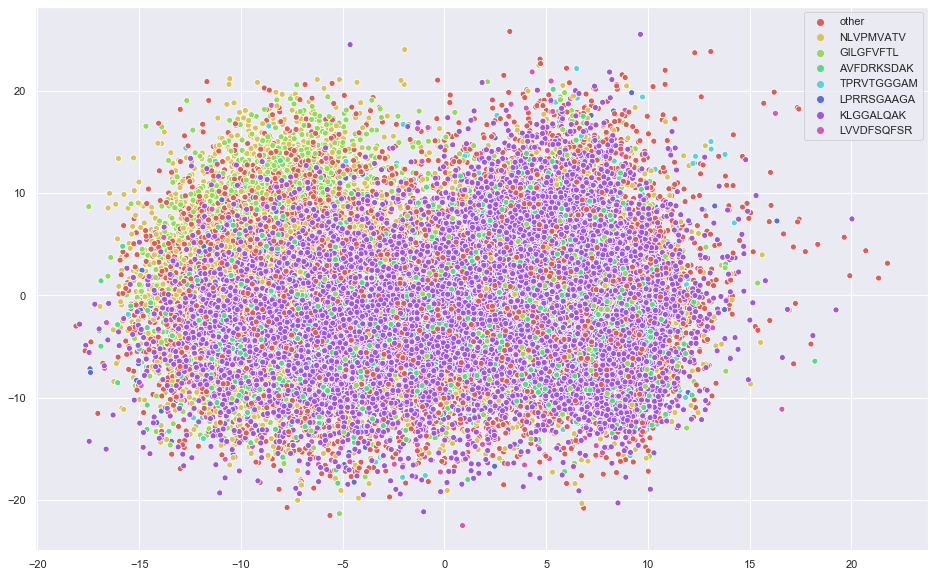

In [958]:
n_epitopes = len(X["palette"].unique())
palette = sns.color_palette("hls", n_epitopes)
hue = list(X["palette"])
sns.set(rc={"figure.figsize": (16, 10)})
sns.scatterplot(
    tsne_data[:, 0], tsne_data[:, 1], legend="full", hue=hue, palette=palette
)